In [1]:
import numpy as np
import PIL as pil
import matplotlib.pyplot as plt
%matplotlib inline
#import cv2
import scipy
import scipy.misc
import scipy.signal
import warnings
import os
import re
import copy
warnings.filterwarnings("ignore", category=DeprecationWarning) 
#plt.rcParams['figure.figsize'] = (50,50)
plt.rcParams['image.cmap'] = 'gray'
import mrc as mrc
import version1 as v1
import version2 as v2
import version3 as v3
import version4 as v4
import statistics

## Adopted code for multiple configurations
Based on previous code, which was copy and paster, I proceed to adjust it to input a folder containing different stacks of particle projections. 
We want to produce a probability image for each of the stacks, based off of these equations:
$$-\log\mathcal{P}(T^k|I) =  -\log\sum_je^{-\mathcal{E}_{jk}} + log\sum_ke^{-\mathcal{E}_k} $$ or 
$$-\log\mathcal{P}(T^k|I) = -\log\mathcal{P}(T^k) -\log\sum_je^{-\mathcal{E}_{jk}} + log\sum_ke^{\log\mathcal{P}(T^k)-\mathcal{E}_k} $$
Where P(T^k) is the prior. Method 1 assumes the prior is constant, and can be cancelled out, method 2 assumes it is not and needs it to be inputted. Thsi is based off of derivation via Bayes' Theorem and marginalization, see the Semi-Formal Writeup for more details. 

In [ ]:
%%time
#Copied over
#Second version of a code that takes image, stack and max_num a computer can work with and produce EK
#Adding functionality for larger template stacks and division errors
def Error_Particle(I, T, max_num):
    I = mrc.readMRC(I)
    T = mrc.readMRC(T)
    Error_Stack = Error_Template(I, T, max_num)
    Particle_Error = -scipy.misc.logsumexp(-Error_Stack, axis=2)
    print('############################')
    return(Particle_Error)
    
def Error_Template(I, T, max_num):
    I = I[:,:,0]
    x, y, z = T.shape
    h, l = I.shape
    
    xcent = int(h/2-x/2)
    ycent = int(l/2-y/2)
    
    padding = np.zeros_like(I)
    padding[xcent:xcent+int(x), ycent:ycent+int(y)] = 1.0
    
    f1 = np.fft.rfft2(I)
    f2 = np.fft.rfft2(padding)
    
    mask = np.zeros_like(I)
    
    EK = Template_Splitting(I,T, x, y, z, xcent, ycent,h,l,f1, f2, padding, mask, max_num)
    print(np.isfortran(EK))
    return(EK)
    
def Template_Splitting(I, T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num, start = 0):
    
    bins = z//max_num
    
    if bins > max_num:
        indices = np.linspace(0,z,max_num+1, dtype = int)
        total_stack = np.empty([h,l,max_num])
        
        for nn in range(max_num):
            slicet = T[:,:,indices[nn]:indices[nn+1]]
            height = slicet.shape[2]

            pp = Template_Splitting(I, slicet, x, y, height, xcent, ycent, h, l ,f1, f2, padding, mask, max_num)
            total_stack[:,:,nn] = -scipy.misc.logsumexp(-pp, axis=2)
        return total_stack
                   
    else:
        
        index = np.arange(start,z,max_num)
        inx_len = len(index)
        ek_stack = np.empty([h, l, inx_len])
        
        ejk_stack = np.empty([h, l, max_num])
        
        for nn in range(inx_len):
            try:
                zed = T[:,:,index[nn]:index[nn+1]]
                
            except IndexError:
                zed = T[:,:,index[nn]:]
                ejk_stack = np.empty([h,l,z-index[nn]])      
            
            for xx in range(zed.shape[2]):
                print('heythere')
                
                
                temp = zed[:,:,xx]
                temp = temp-np.mean(temp)
                
                mask[xcent:xcent+int(x), ycent:ycent+int(y)] = temp[::-1,::-1]
                
                crossc = fast_convolve(I, mask, IFT=f1)
                img_norm = fast_convolve(I**2, padding, PFT = f2)
                temp_norm = np.sum(temp**2)        
                
                ejk_stack[:,:,xx] = (img_norm + temp_norm - 2*crossc)
            
            ek_stack[:,:,nn] = -scipy.misc.logsumexp(-ejk_stack, axis=2)
            
            print('looping')
        
        return ek_stack
                       
    
def fast_convolve(I, T, IFT = 0, PFT = 0):   
    if np.any(IFT):
        
        f2 = np.fft.rfft2(T)
        conv = IFT*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    elif np.any(PFT):
            
        f1 = np.fft.rfft2(I)
            
        conv = f1*PFT
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    else:
        f1 = np.fft.rfft2(I)
        f2 = np.fft.rfft2(T)

        conv = f1*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv)) 
   
    return fc    
    
    
EKTEST1 = Error_Particle('imgdata_52006_1.mrc','imgdata_26005_particle_stack.mrc',15)

In [ ]:
%%time
#Copied over
#Third version of a code that takes image, stack and max_num a computer can work with and produce EK
#Adding functionality for larger template stacks and division errors
#Changing the ordering of the array to conform to C ordering for efficiency
def Error_Particle(I, T, max_num):
    I = mrc.readMRC(I)
    T = mrc.readMRC(T)
    T = np.ascontiguousarray(T)
    Error_Stack = Error_Template(I, T, max_num)
    Particle_Error = -scipy.misc.logsumexp(-Error_Stack, axis=0)
    #print('############################')
    return(Particle_Error)
    
def Error_Template(I, T, max_num):
    I = I[:,:,0]
    x, y, z = T.shape
    h, l = I.shape
    
    xcent = int(h/2-x/2)
    ycent = int(l/2-y/2)
    
    padding = np.zeros_like(I)
    padding[xcent:xcent+int(x), ycent:ycent+int(y)] = 1.0
    
    f1 = np.fft.rfft2(I)
    f2 = np.fft.rfft2(padding)
    
    mask = np.zeros_like(I)
    
    EK = Template_Splitting(I,T, x, y, z, xcent, ycent,h,l,f1, f2, padding, mask, max_num)
    
    return(EK)
    
def Template_Splitting(I, T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num, start = 0):
    
    bins = z//max_num
    
    if bins > max_num:
        indices = np.linspace(0,z,max_num+1, dtype = int)
        total_stack = np.empty([max_num, h, l])
        
        for nn in range(max_num):
            slicet = T[:,:,indices[nn]:indices[nn+1]]
            height = slicet.shape[2]

            pp = Template_Splitting(I, slicet, x, y, height, xcent, ycent, h, l ,f1, f2, padding, mask, max_num)
            total_stack[nn,:,:] = -scipy.misc.logsumexp(-pp, axis=0)
        return total_stack
                   
    else:
        
        index = np.arange(start,z,max_num)
        inx_len = len(index)
        ek_stack = np.empty([inx_len, h, l])
        
        
        ejk_stack = np.empty([max_num,h, l])
        
        
        for nn in range(inx_len):
            try:
                zed = T[:,:,index[nn]:index[nn+1]]
                
            except IndexError:
                zed = T[:,:,index[nn]:]
                
                ejk_stack = np.empty([z-index[nn],h,l])      
            
            for xx in range(zed.shape[2]):
                #print('heythere')
                
                
                temp = zed[:,:,xx]
                temp = temp-np.mean(temp)
                
                mask[xcent:xcent+int(x), ycent:ycent+int(y)] = temp[::-1,::-1]
                
                crossc = fast_convolve(I, mask, IFT=f1)
                img_norm = fast_convolve(I**2, padding, PFT = f2)
                temp_norm = np.sum(temp**2)        
                
                ejk_stack[xx,:,:] = (img_norm + temp_norm - 2*crossc)
                
            
            ek_stack[nn,:,:] = -scipy.misc.logsumexp(-ejk_stack, axis=0)
           
            
            #print('looping')
        
        return ek_stack
                       
    
def fast_convolve(I, T, IFT = 0, PFT = 0):   
    if np.any(IFT):
        
        f2 = np.fft.rfft2(T)
        conv = IFT*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    elif np.any(PFT):
            
        f1 = np.fft.rfft2(I)
            
        conv = f1*PFT
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    else:
        f1 = np.fft.rfft2(I)
        f2 = np.fft.rfft2(T)

        conv = f1*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv)) 
   
    return fc    
    
    
EKTEST2 = Error_Particle('imgdata_52006_1.mrc','imgdata_26005_particle_stack.mrc',15)

We now take in a folder containg particle stacks, and a choice of the methods as described. The code treats each particle stack seperately, but then combines them for the Ek sum. This is the marginalization for P(I). The negative log probability for each stack is then calculated, and the results are returned in a stack.
If method 2 is utilized, the corresponding prior is incorporated into the calculation of the probability. 

In [51]:
%%time
#Version 1 - Taking in a folder with stacks of a particle in different configurations and producing probabilities
#Method 1 assumes the prior are all equal, and methos 2 assumes not and combines into exp
#Method 1: -log(p(s_k|I)) = -logsumexp(-e_jk) + logsumexp(-e_k)
#Method 2: -log(p(s_k|I)) = -log(p(s_k)) - logsumexp(-e_jk) + logsumexp(log(p(s_k))-E_k)

def Config_Prob(I, folder, max_num = 10, method = 1, psk = []):
    I = mrc.readMRC(I)
    I = I[:,:,0]
    h , l = I.shape
    
    num_configs = len([name for name in os.listdir(folder) if os.path.isfile(os.path.join(folder, name)) and name[0] != '.'])
   
    
    ek_stack = np.empty([num_configs, h, l])
    prob_stack = np.empty([num_configs, h, l])
    
    padding = np.zeros_like(I)
    mask = np.zeros_like(I)
    
    f1 = np.fft.rfft2(I)
    
    if method == 1:
        count = 0
        
        for temp_stack in os.listdir(folder):
            
            T = mrc.readMRC(os.path.join(folder, temp_stack))
            T = np.ascontiguousarray(T)

            error_stack = Error_Template(I,T, max_num, f1, padding, mask, h, l)
            config_error = -scipy.misc.logsumexp(-error_stack, axis=0)
            
            ek_stack[count,:,:] = config_error
            count += 1 
            print('innerloop')
            
        ek_sum = scipy.misc.logsumexp(-ek_stack, axis = 0)
        
        
        for temp_stack in range(len(os.listdir(folder))):
            
            neg_prob = ek_stack[temp_stack,:,:] + ek_sum 
            prob_stack[temp_stack,:,:] = neg_prob
            
        return prob_stack
    
        
    
    else:
        count = 0
        
        for temp_stack in os.listdir(folder):
            
            T = mrc.readMRC(os.path.join(folder, temp_stack))
            T = np.ascontiguousarray(T)

            error_stack = Error_Template(I,T, max_num, f1, padding, mask, h, l)
            config_error = -scipy.misc.logsumexp(-error_stack, axis=0)
            
            ek_stack[count,:,:] = config_error
            count += 1 
            
            print('innerloop')
            
        for temp_stack in range(len(os.listdir(folder))):
            
            ek_sum = scipy.misc.logsumexp((np.log(psk[temp_stack])-ek_stack),axis = 0)
            
            neg_prob = -np.log(psk[temp_stack]) + ek_stack[temp_stack,:,:] + ek_sum
            prob_stack[temp_stack,:,:] = neg_prob
        
        return prob_stack
        
        
        
def Error_Template(I, T, max_num, f1, padding, mask, h, l):
    x, y, z = T.shape
    
    xcent = int(h/2-x/2)
    ycent = int(l/2-y/2)
    
    padding[xcent:xcent+int(x), ycent:ycent+int(y)] = 1.0
    f2 = np.fft.rfft2(padding)
    
    ek = Template_Splitting(I,T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num)
    
    return ek

def Template_Splitting(I, T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num, start = 0):
    
    bins = z//max_num
    
    if bins > max_num:
        indices = np.linspace(0,z,max_num+1, dtype = int)
        total_stack = np.empty([max_num, h, l])
        
        for nn in range(max_num):
            slicet = T[:,:,indices[nn]:indices[nn+1]]
            height = slicet.shape[2]

            pp = Template_Splitting(I, slicet, x, y, height, xcent, ycent, h, l ,f1, f2, padding, mask, max_num)
            total_stack[nn,:,:] = -scipy.misc.logsumexp(-pp, axis=0)
        return total_stack
                   
    else:
        
        index = np.arange(start,z,max_num)
        inx_len = len(index)
        ejk_stack_2 = np.empty([inx_len, h, l])
        
        
        ejk_stack = np.empty([max_num,h, l])
        
        
        for nn in range(inx_len):
            try:
                zed = T[:,:,index[nn]:index[nn+1]]
                
            except IndexError:
                zed = T[:,:,index[nn]:]
                ejk_stack = np.empty([z-index[nn],h,l])      
            
            for xx in range(zed.shape[2]):
                #print('heythere')
                
                
                temp = zed[:,:,xx]
                temp = temp-np.mean(temp)
                
                mask[xcent:xcent+int(x), ycent:ycent+int(y)] = temp[::-1,::-1]
                
                crossc = fast_convolve(I, mask, IFT=f1)
                img_norm = fast_convolve(I**2, padding, PFT = f2)
                temp_norm = np.sum(temp**2)        
                
                ejk_stack[xx,:,:] = (img_norm + temp_norm - 2*crossc)
                print('heythere')
            
            ejk_stack_2[nn,:,:] = -scipy.misc.logsumexp(-ejk_stack, axis=0)
            print('looping')
            
            #print('looping')
        
        return ejk_stack_2
                       
    
def fast_convolve(I, T, IFT = 0, PFT = 0):   
    if np.any(IFT):
        
        f2 = np.fft.rfft2(T)
        
        conv = IFT*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    elif np.any(PFT):
            
        f1 = np.fft.rfft2(I)
            
        conv = f1*PFT
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    else:
        
        f1 = np.fft.rfft2(I)
        f2 = np.fft.rfft2(T)

        conv = f1*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv)) 
   
    return fc        
    
z1 = Config_Prob('imgdata_52006_1.mrc', 'test_folder', psk = [0.01, 0.99], method = 1)

heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
innerloop
Wall time: 3min 19s


Instead of returning the negative log probability, this code attempts to return the regular probability. Doesnt work too well as the exp function breaks down at hgih/low values. 

In [77]:
%%time
#Version 2 - Taking in a folder with stacks of a particle in different configurations and producing probabilities
#Method 1 assumes the prior are all equal, and methos 2 assumes not and combines into exp
#Method 1: -log(p(s_k|I)) = -logsumexp(-e_jk) + logsumexp(-e_k)
#Method 2: -log(p(s_k|I)) = -log(p(s_k)) - logsumexp(-e_jk) + logsumexp(log(p(s_k))-E_k)
#Trying to change it so that the output is p(sk|I)

def Config_Prob(I, folder, max_num = 10, method = 1, psk = []):
    I = mrc.readMRC(I)
    I = I[:,:,0]
    h , l = I.shape
    
    num_configs = len([name for name in os.listdir(folder) if os.path.isfile(os.path.join(folder, name)) and name[0] != '.'])
   
    
    ek_stack = np.empty([num_configs, h, l])
    prob_stack = np.empty([num_configs, h, l])
    
    padding = np.zeros_like(I)
    mask = np.zeros_like(I)
    
    f1 = np.fft.rfft2(I)
    
    if method == 1:
        count = 0
        
        for temp_stack in os.listdir(folder):
            
            T = mrc.readMRC(os.path.join(folder, temp_stack))
            T = np.ascontiguousarray(T)

            error_stack = Error_Template(I,T, max_num, f1, padding, mask, h, l)
            config_error = -scipy.misc.logsumexp(-error_stack, axis=0)
            
            ek_stack[count,:,:] = config_error
            count += 1 
            
            print('innerloop')
            
        ek_sum = scipy.misc.logsumexp(-ek_stack, axis = 0)
               
        
        for temp_stack in range(len(os.listdir(folder))):
            
            
            prob = (ek_stack[temp_stack,:,:] + ek_sum)
            prob_stack[temp_stack,:,:] = np.exp(-prob)
            
        return prob_stack
    
        
    
    else:
        count = 0
        
        for temp_stack in os.listdir(folder):
            
            T = mrc.readMRC(os.path.join(folder, temp_stack))
            T = np.ascontiguousarray(T)

            error_stack = Error_Template(I,T, max_num, f1, padding, mask, h, l)
            config_error = -scipy.misc.logsumexp(-error_stack, axis=0)
            
            ek_stack[count,:,:] = config_error
            count += 1 
            
            print('innerloop')
            
        for temp_stack in range(len(os.listdir(folder))):
            
            ek_sum = scipy.misc.logsumexp((np.log(psk[temp_stack])-ek_stack),axis = 0)
            
            prob = -np.log(psk[temp_stack]) + ek_stack[temp_stack,:,:] + ek_sum
          
            prob_stack[temp_stack,:,:] = prob
        
        return prob_stack
        
        
        
def Error_Template(I, T, max_num, f1, padding, mask, h, l):
    x, y, z = T.shape
    
    xcent = int(h/2-x/2)
    ycent = int(l/2-y/2)
    
    padding[xcent:xcent+int(x), ycent:ycent+int(y)] = 1.0
    f2 = np.fft.rfft2(padding)
    
    ek = Template_Splitting(I,T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num)
    
    return ek

def Template_Splitting(I, T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num, start = 0):
    
    bins = z//max_num
    
    if bins > max_num:
        indices = np.linspace(0,z,max_num+1, dtype = int)
        total_stack = np.empty([max_num, h, l])
        
        for nn in range(max_num):
            slicet = T[:,:,indices[nn]:indices[nn+1]]
            height = slicet.shape[2]

            pp = Template_Splitting(I, slicet, x, y, height, xcent, ycent, h, l ,f1, f2, padding, mask, max_num)
            total_stack[nn,:,:] = -scipy.misc.logsumexp(-pp, axis=0)
        return total_stack
                   
    else:
        
        index = np.arange(start,z,max_num)
        inx_len = len(index)
        ejk_stack_2 = np.empty([inx_len, h, l])
        
        
        ejk_stack = np.empty([max_num,h, l])
        
        
        for nn in range(inx_len):
            try:
                zed = T[:,:,index[nn]:index[nn+1]]
                
            except IndexError:
                zed = T[:,:,index[nn]:]
                ejk_stack = np.empty([z-index[nn],h,l])      
            
            for xx in range(zed.shape[2]):
                #print('heythere')
                
                
                temp = zed[:,:,xx]
                temp = temp-np.mean(temp)
                
                mask[xcent:xcent+int(x), ycent:ycent+int(y)] = temp[::-1,::-1]
                
                crossc = fast_convolve(I, mask, IFT=f1)
                img_norm = fast_convolve(I**2, padding, PFT = f2)
                temp_norm = np.sum(temp**2)        
                
                ejk_stack[xx,:,:] = (img_norm + temp_norm - 2*crossc)
                print('heythere')
            
            ejk_stack_2[nn,:,:] = -scipy.misc.logsumexp(-ejk_stack, axis=0)
            print('looping')
            
            #print('looping')
        
        return ejk_stack_2
                       
    
def fast_convolve(I, T, IFT = 0, PFT = 0):   
    if np.any(IFT):
        
        f2 = np.fft.rfft2(T)
        
        conv = IFT*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    elif np.any(PFT):
            
        f1 = np.fft.rfft2(I)
            
        conv = f1*PFT
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    else:
        
        f1 = np.fft.rfft2(I)
        f2 = np.fft.rfft2(T)

        conv = f1*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv)) 
   
    return fc        
    
z1 = Config_Prob('imgdata_52006_1.mrc', 'test_folder', psk = [0.1, 0.9], method = 1)

heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythe

Until now sigma was implicitly defined as 1/sqrt(2). Now we have a way to estimate it. sample_num points are randomly chosen from the image, the average of them is calculated, and the variance of all the points is calculated. This is then summed and divided by the number of points. This is repeated avg_num times, and then the median is taken. There is a mistake, as this results in sigma^2, so it should be square rooted. 

This sigma is then passed on in the code and used for the calculations. The useer can also manual input the sigma parameter is they so wish. 

In [5]:
%%time
#Version 3 - Taking in a folder with stacks of a particle in different configurations and producing probabilities.
#Implementing sigma as a parameter and estimation.

def Config_Prob(I, folder, max_num = 10, method = 1, sigma = 0, psk = []):
    I = mrc.readMRC(I)
    I = I[:,:,0]
    h , l = I.shape
    
    num_configs = len([name for name in os.listdir(folder) if os.path.isfile(os.path.join(folder, name)) and name[0] != '.'])
    
    if sigma == 0:
        #Calculate variance for 5 points, 10 times and take median
        avg_num = 10
        sample_num = 5
        sigma_list = np.empty([avg_num,1])
        for nn in range(avg_num):

            x = np.random.randint(0, h, size = sample_num)
            y = np.random.randint(0,l, size = sample_num)
            vbar = 0
            
            for mm in range(sample_num):
                vbar = vbar + I[x[mm]][y[mm]]
                
            sigma = 0
            vbar = vbar * 1/sample_num
            
            for mm in range(sample_num):
                sigma = sigma + (I[x[mm]][y[mm]]- vbar)**2
                
            sigma = sigma * 1/sample_num
            sigma_list[nn] = sigma
            
        sigma = statistics.median(sigma_list)[0]
        
        
    else:
        None
        
    print(sigma)
        
    ek_stack = np.empty([num_configs, h, l])
    prob_stack = np.empty([num_configs, h, l])
    
    padding = np.zeros_like(I)
    mask = np.zeros_like(I)
    
    f1 = np.fft.rfft2(I)
    
    if method == 1:
        count = 0
        
        for temp_stack in os.listdir(folder):
            
            T = mrc.readMRC(os.path.join(folder, temp_stack))
            T = np.ascontiguousarray(T)

            error_stack = Error_Template(I,T, max_num, f1, padding, mask, h, l, sigma)
            config_error = -scipy.misc.logsumexp(-error_stack, axis=0)
            
            ek_stack[count,:,:] = config_error
            count += 1 
            
            print('innerloop')
            
        ek_sum = scipy.misc.logsumexp(-ek_stack, axis = 0)
               
        
        for temp_stack in range(len(os.listdir(folder))):
            
            
            prob = (ek_stack[temp_stack,:,:] + ek_sum)
            prob_stack[temp_stack,:,:] = np.exp(-prob)
            
        return (prob_stack, ek_stack, ek_sum)
    
        
    
    else:
        count = 0
        
       
        for temp_stack in os.listdir(folder):
            
            T = mrc.readMRC(os.path.join(folder, temp_stack))
            T = np.ascontiguousarray(T)

            error_stack = Error_Template(I,T, max_num, f1, padding, mask, h, l, sigma)
            config_error = -scipy.misc.logsumexp(-error_stack, axis=0)
            
            ek_stack[count,:,:] = config_error
            count += 1 
            
            print('innerloop')
            
        for temp_stack in range(len(os.listdir(folder))):
            
            ek_sum = scipy.misc.logsumexp((np.log(psk[temp_stack])-ek_stack),axis = 0)
            
            prob = -np.log(psk[temp_stack]) + ek_stack[temp_stack,:,:] + ek_sum
          
            prob_stack[temp_stack,:,:] = np.exp(-prob)
        
        return (prob_stack, ek_stack, ek_sum)
        
        
        
def Error_Template(I, T, max_num, f1, padding, mask, h, l, sigma):
    x, y, z = T.shape
    
    xcent = int(h/2-x/2)
    ycent = int(l/2-y/2)
    
    padding[xcent:xcent+int(x), ycent:ycent+int(y)] = 1.0
    f2 = np.fft.rfft2(padding)
    
    ek = Template_Splitting(I,T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num, sigma)
    
    return ek

def Template_Splitting(I, T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num, sigma, start = 0):
    
    bins = z//max_num
    
    if bins > max_num:
        indices = np.linspace(0,z,max_num+1, dtype = int)
        total_stack = np.empty([max_num, h, l])
        
        for nn in range(max_num):
            slicet = T[:,:,indices[nn]:indices[nn+1]]
            height = slicet.shape[2]

            pp = Template_Splitting(I, slicet, x, y, height, xcent, ycent, h, l ,f1, f2, padding, mask, max_num)
            total_stack[nn,:,:] = -scipy.misc.logsumexp(-pp, axis=0)
        return total_stack
                   
    else:
        
        index = np.arange(start,z,max_num)
        inx_len = len(index)
        ejk_stack_2 = np.empty([inx_len, h, l])
        
        
        ejk_stack = np.empty([max_num,h, l])
        
        
        for nn in range(inx_len):
            try:
                zed = T[:,:,index[nn]:index[nn+1]]
                
            except IndexError:
                zed = T[:,:,index[nn]:]
                ejk_stack = np.empty([z-index[nn],h,l])      
            
            for xx in range(zed.shape[2]):
                #print('heythere')
                
                
                temp = zed[:,:,xx]
                temp = temp-np.mean(temp)
                
                mask[xcent:xcent+int(x), ycent:ycent+int(y)] = temp[::-1,::-1]
                
                crossc = fast_convolve(I, mask, IFT=f1)
                img_norm = fast_convolve(I**2, padding, PFT = f2)
                temp_norm = np.sum(temp**2)        
                
                ejk_stack[xx,:,:] = (1/(2*sigma**2))*(img_norm + temp_norm - 2*crossc)
                print('heythere')
            
            ejk_stack_2[nn,:,:] = -scipy.misc.logsumexp(-ejk_stack, axis=0)
            print('looping')
            
            #print('looping')
        
        return ejk_stack_2
                       
    
def fast_convolve(I, T, IFT = 0, PFT = 0):   
    if np.any(IFT):
        
        f2 = np.fft.rfft2(T)
        
        conv = IFT*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    elif np.any(PFT):
            
        f1 = np.fft.rfft2(I)
            
        conv = f1*PFT
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    else:
        
        f1 = np.fft.rfft2(I)
        f2 = np.fft.rfft2(T)

        conv = f1*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv)) 
   
    return fc        
    
z1 = Config_Prob('imgdata_52006_1.mrc', 'test_folder', psk = [0.1, 0.9], method = 1)

0.12857434075691312
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
innerloop
Wall time: 1min 38s


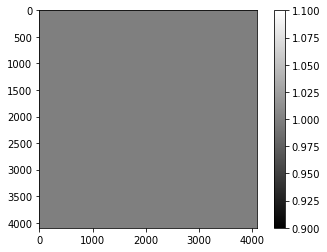

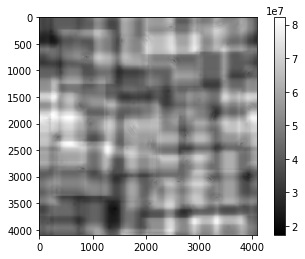

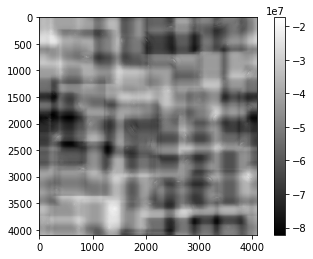

In [6]:
# plt.figure()
# plt.imshow(z1[0][0,:,:])
# plt.colorbar()
# plt.figure()
# plt.imshow(z1[0][1,:,:])
# plt.colorbar()
# plt.figure()
# plt.imshow(z1[1][0,:,:])
# plt.colorbar()
# plt.figure()
# plt.imshow(z1[1][1,:,:])
# plt.colorbar()
# plt.figure()
# plt.imshow(z1[2])
# plt.colorbar()

for nn in range(z1[0].shape[0]):
    plt.figure()
    plt.imshow(z1[0][nn,:,:])
    plt.colorbar()
    #scipy.misc.imsave('yorkA' + str(nn) + '.png', z1[0][nn,:,:])
    
for mm in range(z1[0].shape[0]):
    plt.figure()
    plt.imshow(z1[1][mm,:,:])
    plt.colorbar()
    #scipy.misc.imsave('yorkB' + str(mm) + '.png', z1[1][mm,:,:])
    
plt.figure()
plt.imshow(z1[2])
plt.colorbar()
#scipy.misc.imsave('yorkC.png', z1[2])

In [7]:
dred = z1[0][3,:,:]
dred = -dred
dred = dred + 1


plt.imshow(dred)
plt.colorbar()
scipy.misc.imsave('yorkA3_2.png', dred)

IndexError: index 3 is out of bounds for axis 0 with size 1